### Initializing the network

- We implement [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

#### Two major issues in the initialization:
- Last layer likely to predict incorrect predictions with a lot of confidence initially due to random weights
- Preactivations are super skewed (many 1s and -1s). Tanh gives ~0 gradient when values are close to -1 and 1 and passes the gradient (\*1) through if the values are close to ~0. (Gradient Vanishes, dead neurons). 

#### Why is unchecked random assignment for Weights not a good idea?
- More likely to amplify loss
- A potential solution is to keep weights close to uniform

- Scaling factors can be found in this paper: https://arxiv.org/pdf/1502.01852
- Kaiming initialization ()
 
 
##### Modern innovations like Residual connections, Number of Normalization Layers (such as batch normalization), and much better optimers compared to gradient descent (such as Adam optimizer) makes it less important to ensure a good initialization 

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [88]:
# read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [89]:
len(words)

32033

In [90]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [103]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
# n1 = 20
# n2 = 30

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [104]:
# Xtr[0:10], Ytr[0:10]

In [150]:
n_embd = 10
n_hidden = 200
vs = 27    # vocab size

g = torch.Generator().manual_seed(42) # for reproducibility
C = torch.randn((vs, n_embd), generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2 #* (5/3)/(n_embd * block_size) #**0.5 # * 0.2  or * (5/3)/(n_embd * block_size)**0.5
b1 = torch.randn(n_hidden, generator=g)    * 0.01
W2 = torch.randn((n_hidden, vs), generator=g) * 0.01
b2 = torch.randn(vs, generator=g) * 0

bn_gain = torch.ones((1, n_hidden))
bn_bias = torch.zeros((1, n_hidden))
bn_mean_running = torch.ones((1, n_hidden))
bn_std_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2] #, bn_gain, bn_bias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total

for p in parameters:
    p.requires_grad = True


11697


In [151]:
lossi = []
stepi = []

In [152]:
# h_pre_act.std(0, keepdims = True)

In [153]:
# import sys
batch_size = 32
for i in range(200000):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)   ### random sampling

    Xb, Yb = Xtr[ix], Ytr[ix]      ## batch of training examples
    # forward pass
    emb = C[Xb] # (32, 3, 2)         ## Looking up embeddings (i.e., features corresponding to inputs)
    emb_concat = emb.view(emb.shape[0], -1)     ## concatenate vectors (creating features to feed into the hidden layer)
    h_pre_act = emb_concat @ W1 + b1    ## Hidden layer pre activation
#     bn_mean_i = h_pre_act.mean(0, keepdims = True)
#     bn_std_i = h_pre_act.std(0, keepdims = True)
#     h_pre_act = bn_gain * (h_pre_act - bn_mean_i)/ bn_std_i + bn_bias  ## Normalizing activation layer output 
    
#     with torch.no_grad():
#         bn_mean_running = 0.999 * bn_mean_running + 0.001 * bn_mean_i
#         bn_std_running = 0.999 * bn_std_running + 0.001 * bn_std_i
    
    h = torch.tanh(h_pre_act) # (32, 100)    ## Hidden layer activation
    logits = h @ W2 + b2 # (32, 27)       ## Hidden layer output
    
    loss = F.cross_entropy(logits, Yb)      ## nll loss
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    if(i % 10000 == 0):
        print(loss)
    
    stepi.append(i)
    lossi.append(loss.log10().item())
    
    break

print(loss.item())

tensor(3.3027, grad_fn=<NllLossBackward0>)
3.3027122020721436


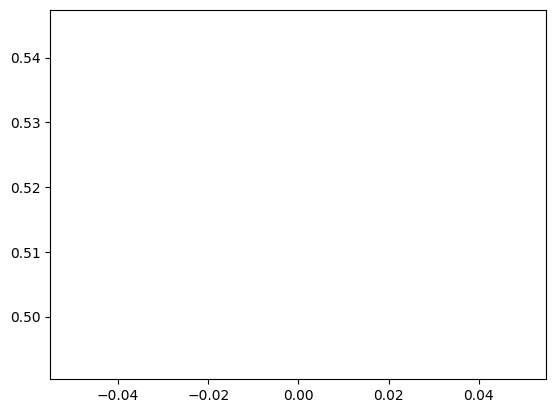

In [154]:
plt.plot(stepi, lossi)

In [117]:
import math
-math.log(1/27)

3.295836866004329

In [57]:
print(-torch.tensor(1/27).log())             ## loss when all characters are equally probably (i.e., baseline loss)
# logits = torch.rand(4)
# logits = torch.tensor([-3.0, 5.0, 1.0, 4.0])
# probs = torch.softmax(logits, dim = 0)
# loss = - probs[2].log()
# logits, probs, loss

tensor(3.2958)


##### Training loss

In [34]:
emb = C[Xtr] # (32, 3, 2)
emb_concat = emb.view(emb.shape[0], -1)     ## concatenate vectors (creating features to feed into the hidden layer)
h_pre_act = emb_concat @ W1 + b1    ## Hidden layer pre activation
h_pre_act = bn_gain * (h_pre_act - bn_mean_running)/bn_std_running + bn_bias  ## Normalizing activation layer output 
h = torch.tanh(h_pre_act) # (32, 100)    ## Hidden layer activation
logits = h @ W2 + b2

# h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
# logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0663, grad_fn=<NllLossBackward0>)

##### Validaton Loss

In [35]:
emb = C[Xdev] # (32, 3, 2)
emb_concat = emb.view(emb.shape[0], -1)     ## concatenate vectors (creating features to feed into the hidden layer)
h_pre_act = emb_concat @ W1 + b1    ## Hidden layer pre activation
h_pre_act = bn_gain * (h_pre_act - bn_mean_running)/bn_std_running + bn_bias  ## Normalizing activation layer output 
h = torch.tanh(h_pre_act) # (32, 100)    ## Hidden layer activation
logits = h @ W2 + b2
# h = torch.tanh(emb.view(-1, 50) @ W1 + b1) # (32, 100)
# logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1243, grad_fn=<NllLossBackward0>)

### Lets look at Activations and PreActivations

In [ ]:
h #logits

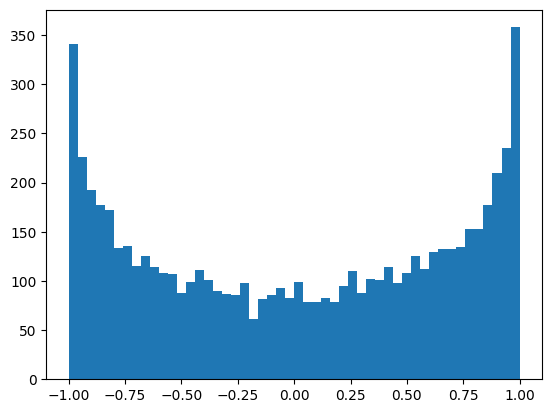

In [155]:
plt.hist(h.view(-1).tolist(), 50);

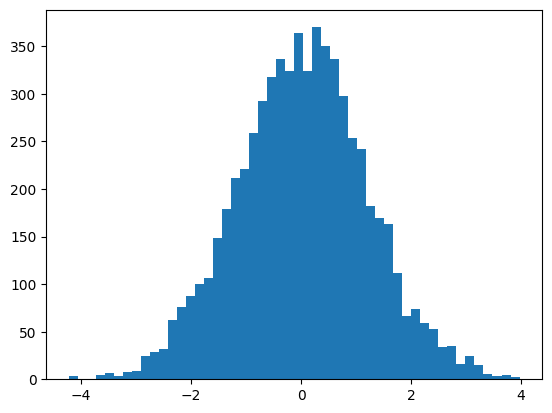

In [156]:
plt.hist(h_pre_act.view(-1).tolist(), 50);

### Dead neurons

- Dead neurons are created when a column of h (activations) is all 1s or -1s. The gradients in that case would be all 0s and the dot product with anything for that column would yield a 0, hence a dead neuron (in W). Dead neurons are incapable of training as no gradient passes through them, hence no change in weights.

- Dead nuerons could become a problem with any activation function that has flat tails (example, sigmoid, tanh, ReLU). Soultion is: Leaky ReLU (max(0.1x,x))

- No training example ever activates a dead neuron

- Sometimes due to high learning rates, some neurons may be knocked off to flat tails and eventually become dead

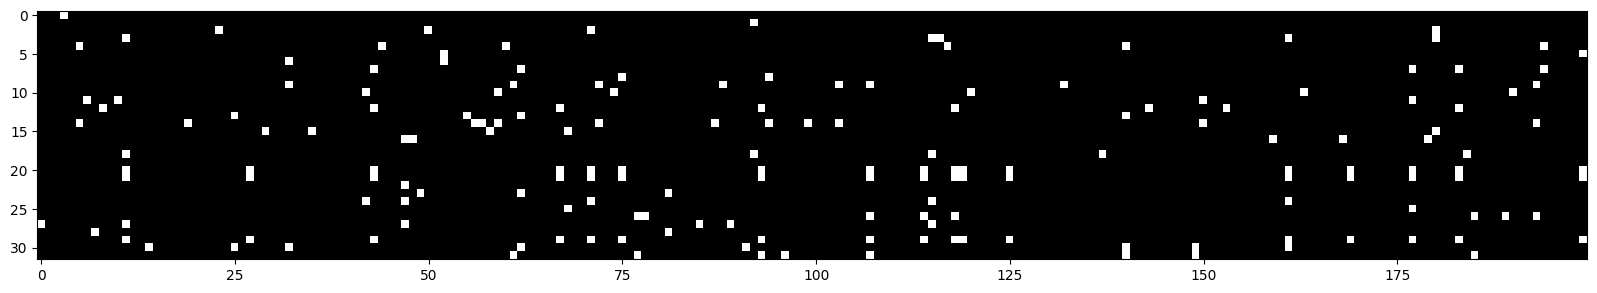

In [157]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs() > 0.99, cmap = 'gray', interpolation = 'nearest')

#### How can we fix dead Neurons?
- By ensuring that Activations take reasonable values (pre activations should be close to unit gaussian)

### Ensuring Activations take on reasonable values (close to unit gaussian)

- Refer to paper: https://dl.acm.org/doi/abs/10.1109/ICCV.2015.123 for optimal values
- Pytorch implementation: https://pytorch.org/docs/stable/nn.init.html

- Demonstration of Kaiming normalization

X mean:  tensor(0.0020) std:  tensor(1.0015)
Y mean:  tensor(-0.0011) std:  tensor(1.0504)


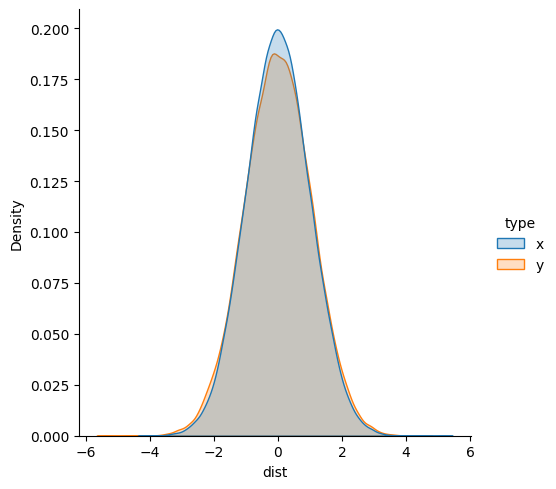

In [160]:
import pandas as pd
import seaborn as sns

x = torch.randn(1000, 100)
w = torch.randn(100, 200)  
w_act = torch.tanh(w) * 5/(3 * 100**0.5) ### * 0.2 or * 5? (/10**0.5)
y = x @ w_act
print("X mean: ", x.mean(), "std: ", x.std())
print("Y mean: ", y.mean(), "std: " ,y.std())

x = x.view(-1)
y = torch.Tensor(pd.Series(y.view(-1)).sample(x.view(-1).shape[0]).tolist())
# y = y.view(-1)

df = pd.DataFrame()
df['dist'] = x
df['type'] = ['x'] * df.shape[0]

df_ = pd.DataFrame()
df_['dist'] = y
df_['type'] = ['y'] * df_.shape[0]

df = pd.concat((df, df_), axis = 0)

sns.displot(df, x = 'dist', hue="type", kind="kde", fill=True)

# Modern innovations that help with these issues (optimal initialization less of an issue now):
# Normalization (Batch, Layer, Group)
# Residual connections
# Better Optimizers than Gradient Descent (Adam optimizer)

In [ ]:
x.std(), w.std(), y.std()

In [ ]:
x.mean(), w.mean(), y.mean()

### Batch Normalization

In [15]:
### Computing batch mean and std. to be used at inference

with torch.no_grad():
    
    emb = C[Xtr]
    emb_concat = emb.view(emb.shape[0], -1)
    h_pre_act = emb_concat @ W1 + b1
    
    bn_mean = h_pre_act.mean(0, keepdims = True)
    bn_std = h_pre_act.std(0, keepdims = True)

In [18]:
bn_mean[0]

tensor([-2.1124,  0.1998, -1.1114,  1.6529,  0.5888,  0.1967,  3.1384, -1.0810,
         1.0420,  0.2558, -1.7771, -2.4019, -0.8887, -0.1092, -0.0749,  0.9403,
        -0.1133, -2.2342, -0.7723,  1.0172,  0.6484,  0.0561, -1.1466,  0.6435,
         1.7602,  1.9486,  1.1539,  0.3976,  0.9565,  1.6923,  0.3432, -1.4226,
        -0.0764, -0.0993, -1.0523, -0.8364, -0.6504,  0.3662, -0.4756,  0.8928,
         0.3035, -0.3340,  0.0215, -0.0733,  0.3006,  0.9378,  1.4841, -1.4514,
         2.8167,  1.3146,  1.9130, -0.7064,  1.7178,  0.8700,  1.3394, -2.1420,
        -0.6629,  0.9004,  1.4092, -1.0025, -0.5022,  0.5177,  1.4055,  0.3087,
         1.2340,  1.1906, -0.4272,  1.1478, -1.1972, -0.2242, -0.1803,  0.5114,
         0.1127, -1.5429, -2.2113,  0.3358,  0.8577,  0.0585,  0.2979,  0.7609,
         0.3021,  1.5997,  0.5954,  0.6403,  0.2959, -0.7417, -1.0491,  0.0400,
         2.0258, -0.3119, -0.8031,  0.3354, -1.2299, -0.6821, -0.7503,  0.6512,
        -0.2135,  0.4422,  0.1584, -0.86

In [19]:
bn_mean_running[0]

tensor([-2.1184e+00,  1.9538e-01, -1.0967e+00,  1.6412e+00,  6.0336e-01,
         1.9966e-01,  3.1363e+00, -1.0608e+00,  1.0317e+00,  2.5627e-01,
        -1.7622e+00, -2.4068e+00, -8.9282e-01, -1.0704e-01, -1.0113e-01,
         9.3335e-01, -1.3262e-01, -2.2472e+00, -7.7249e-01,  1.0062e+00,
         6.5087e-01,  3.9698e-02, -1.1702e+00,  6.4467e-01,  1.7609e+00,
         1.9461e+00,  1.1584e+00,  3.9184e-01,  9.4901e-01,  1.6757e+00,
         3.5242e-01, -1.4314e+00, -6.6215e-02, -1.0464e-01, -1.0555e+00,
        -8.3517e-01, -6.4479e-01,  3.7426e-01, -4.6872e-01,  8.8067e-01,
         3.0197e-01, -3.1266e-01,  1.6541e-02, -7.1725e-02,  3.0511e-01,
         9.5337e-01,  1.4721e+00, -1.4319e+00,  2.8278e+00,  1.3265e+00,
         1.9153e+00, -6.8789e-01,  1.7127e+00,  8.6630e-01,  1.3341e+00,
        -2.1325e+00, -6.6140e-01,  9.0999e-01,  1.4134e+00, -1.0025e+00,
        -4.8362e-01,  5.1648e-01,  1.4164e+00,  3.2516e-01,  1.2502e+00,
         1.1900e+00, -4.3184e-01,  1.1440e+00, -1.1

In [22]:
torch.allclose(bn_mean_running[0], bn_mean[0], atol = 1e-1)

True

In [ ]:
emb_concat.shape

In [36]:
# sample from the model
g = torch.Generator().manual_seed(42)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        
        
      emb = C[torch.tensor([context])] # (1,block_size,d)
      emb_concat = emb.view(emb.shape[0], -1)     ## concatenate vectors (creating features to feed into the hidden layer)
      h_pre_act = emb_concat @ W1 + b1    ## Hidden layer pre activation
      # h_pre_act = bn_gain * (h_pre_act - bn_mean)/bn_std + bn_bias  ## Normalizing activation layer output 
      h_pre_act = bn_gain * (h_pre_act - bn_mean_running)/bn_std_running + bn_bias
      h = torch.tanh(h_pre_act) # (32, 100)    ## Hidden layer activation
      logits = h @ W2 + b2
      
      # h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      # logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

yeosyah.
malin.
dlee.
khalei.
nya.
tryckendeen.
emberlynn.
ise.
abdeles.
lon.
torreeveri.
pep.
lannezika.
shahladie.
ena.
luna.
adari.
zerianne.
nehedanmoll.
eisiony.
